In [12]:
from source_data import Requests
from utils import format_time
from ride_share import DATES,DAY_NAMES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [13]:
# get the requests and measure volume per window
requests = Requests().read_requests()
requests.head()

,time,from_node,to_node,window,day,hour,latest_pickup
0,0,1167,1956,0,0,0,120
1,0,1669,1243,0,0,0,120
2,0,1609,1632,0,0,0,120
3,0,1092,910,0,0,0,120
4,0,1278,867,0,0,0,120


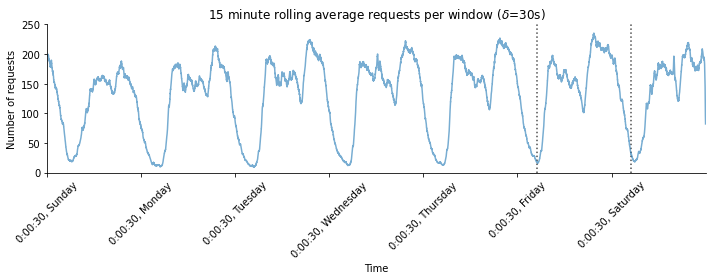

In [38]:
# summarise the requests by hour
numreqs_by_window = requests.groupby(['window']).agg('count')['time'].rename("num_requests")

# create a readable axis
# ticks are windows
xticks = range(0,int(60*60*24*7/30))
skippage = 1440*2
times_seconds = [ 30*w+30 for w in xticks[::skippage] ]

# labels should reflect date-times
xlabels = [f"{format_time((t//3600)%24,t)}, {DAY_NAMES[t//(3600*24)]}" for t in times_seconds]

# count the number of request picked up in each window
fig,ax = plt.subplots(figsize=[10,4])
numreqs_by_window.rolling(30).mean().plot(alpha=0.6,ax=ax)

# try to stick a line on Friday morning to Saturday mornging
offset = 120*5+1
ax.vlines([5*24*120+offset,6*24*120+offset],ymin=[0,0],ymax=[300,300],ls=":",color='black',alpha=0.7)

ax.set_title("15 minute rolling average requests per window ($\delta$=30s)")
ax.set_ylabel("Number of requests")
ax.set_xlabel("Time")
ax.set_xticks(xticks[::skippage])
ax.set_xticklabels(xlabels,rotation=45)
ax.set_ylim([0,250])
ax.set_xlim([0,20160])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/count_allrequests.jpg")

In [11]:
# count the number of picked up picked up requests
# but remove the duplicate pickups
clean_pickups = out_df.groupby(['passenger_id']).apply(lambda x: x.sort_values(['time_stamp']).iloc[0]).reset_index(drop=True)
assert clean_pickups['event'].value_counts().values[0] == len(out_df['passenger_id'].unique())

In [12]:
# get the timewindows for the pickups
pickups = clean_pickups.join(reqs.loc[:,'window'],on=['passenger_id'])
numpicks_by_window = pickups.groupby(['window']).agg('count')['time_stamp'].rename("num_pickups")

# stick it all together
result = pd.concat([numreqs_by_window,numpicks_by_window],axis=1)
result.head()

,num_requests,num_pickups
window,,
0,301,300.0
1,96,96.0
2,320,320.0
3,82,82.0
4,299,299.0


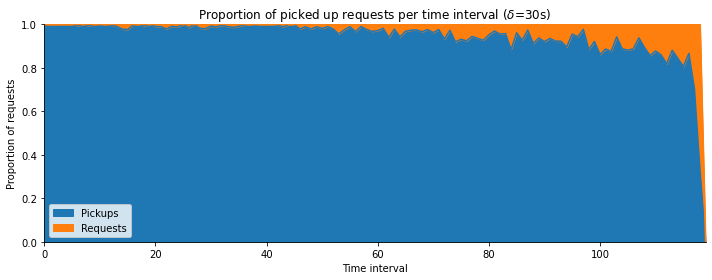

In [13]:
# need to convert to proportion
proportion = result.copy()
proportion['Pickups'] = proportion['num_pickups'] / proportion['num_requests']
proportion['Requests'] = 1 - proportion['Pickups']

# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = proportion.loc[:,['Pickups','Requests']].plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time interval")
ax.set_ylabel("Proportion of requests")
ax.set_title("Proportion of picked up requests per time interval ($\delta$=30s)")
ax.set_xlim([0,119])
ax.set_ylim([0,1])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/proportion.jpg")

In [14]:
# finally show the cab utilisation
cab_use = []
time_index = pd.Series(list(range(0,3600)),name="time_index")
for cab,data in out_df.groupby(['cab_id']):
    
    state = data.copy().sort_values(['time_stamp'])
    state['change'] = data['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
    state['capacity'] = np.cumsum(state['change'])
    
    # add all time to the cab
    state = state.join(time_index,on=['time_stamp'],how='right').iloc[:,[0,2,6]]#.set_index(['time_stamp'])
    
    # if the capacity at time 0 is na then set it to 0
    if state['capacity'].isnull().iloc[0]:
        state.iloc[0,1] = cab
        state.iloc[0,2] = 0
        
    
    # now fill down to the next state change
    state = state.fillna(method='ffill')
    state['utilised'] = state['capacity'].map(lambda x: 1 if x > 0 else 0)
#     print(state.head())
    cab_use.append(state)

# join it all together
cab_use = pd.concat(cab_use).reset_index(drop=True)
cab_use.head()

,time_stamp,cab_id,capacity,utilised
0,0,v0,0.0,0
1,1,v0,0.0,0
2,2,v0,0.0,0
3,3,v0,0.0,0
4,4,v0,0.0,0


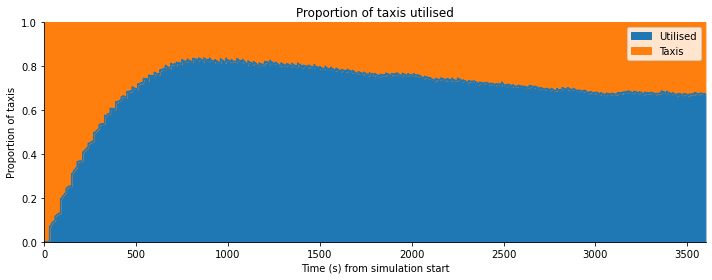

In [15]:
# now count utilised by time
utilised_count = cab_use.groupby(['time_stamp'])['utilised'].agg(['sum']).reset_index(drop=True)

# now caculate the proportion utilised
proportion_utilised = utilised_count / 3000
diff_utilised = 1 - proportion_utilised
to_plot = pd.concat([proportion_utilised,diff_utilised],axis=1)
to_plot.columns = ["Utilised","Taxis"]

# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = to_plot.plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time (s) from simulation start")
ax.set_ylabel("Proportion of taxis")
ax.set_title("Proportion of taxis utilised")
ax.set_xlim([0,3600])
ax.set_ylim([0,1])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/proportion_cabs.jpg")

In [13]:
# interesting cab = v740
focus = 'v740'

# follow a cap that doesn't have lots of errors
cab_data = out_df.groupby(['cab_id'])
# for cab,data in cab_data:
    
#     # count pickups and drop offs
#     picks_drops = (data['passenger_id'].astype(str)+
#                    " "+data['event']).value_counts()
#     if picks_drops.values[0] == 1:
        
#         print(data)
to_focus = cab_data.get_group('v740')
to_focus

,time_stamp,passenger_id,cab_id,event,location
868,150,861,v740,pickup,1562
4963,622,861,v740,dropoff,2877
9956,1020,6573,v740,pickup,2989
21157,1937,6573,v740,dropoff,359
21850,1987,12663,v740,pickup,185
22178,2033,12995,v740,pickup,341
24975,2278,12663,v740,dropoff,1011
34143,3070,12995,v740,dropoff,2702
34456,3090,19479,v740,pickup,2702
34457,3098,19530,v740,pickup,2677


In [14]:
# check the capacity of the cab
state = to_focus.copy()
state['change'] = to_focus['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
state['capacity'] = np.cumsum(state['change'])
state

,time_stamp,passenger_id,cab_id,event,location,change,capacity
868,150,861,v740,pickup,1562,1,1
4963,622,861,v740,dropoff,2877,-1,0
9956,1020,6573,v740,pickup,2989,1,1
21157,1937,6573,v740,dropoff,359,-1,0
21850,1987,12663,v740,pickup,185,1,1
22178,2033,12995,v740,pickup,341,1,2
24975,2278,12663,v740,dropoff,1011,-1,1
34143,3070,12995,v740,dropoff,2702,-1,0
34456,3090,19479,v740,pickup,2702,1,1
34457,3098,19530,v740,pickup,2677,1,2
